# Generative Adversarial Networks - Fruits

Based on [https://www.tensorflow.org/tutorials/generative/dcgan](https://www.tensorflow.org/tutorials/generative/dcgan); modified from MNIST to Fruits-360 data.

## Setup


In [50]:
## checkpoint directory for saving model weights
checkpoint_base_dir = './checkpoints'

In [51]:
## Data is stored locally in ./data folder
## No kagglehub download needed

In [52]:
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def show_img_data(images, no=100, layout=(10, 10), figsize=(6, 6)):
    """Display images in a grid layout."""
    if hasattr(images, 'numpy'):
        images = images.numpy()
    
    rows, cols = layout
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    
    for i in range(min(no, len(images), rows * cols)):
        img = images[i]
        # Handle different image formats
        if img.min() < 0:
            img = (img + 1) / 2  # Scale from [-1, 1] to [0, 1]
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].axis('off')
    
    # Hide any unused subplots
    for i in range(min(no, len(images), rows * cols), rows * cols):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [53]:
## Data is already in local ./data folder
## Contents: Training/ and Test/ directories

In [54]:
train_data_dir = './data/Training'

batch_size = 128
img_size = (32, 32)

In [55]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    shuffle=True,
    seed=4232,
    image_size=img_size,
    batch_size=batch_size)

Found 128252 files belonging to 245 classes.


In [56]:
## put everything into a numpy array for better performance
train_x_list = [img_batch.numpy() / 255. for img_batch, _ in train_data]
train_x = np.concatenate(train_x_list)

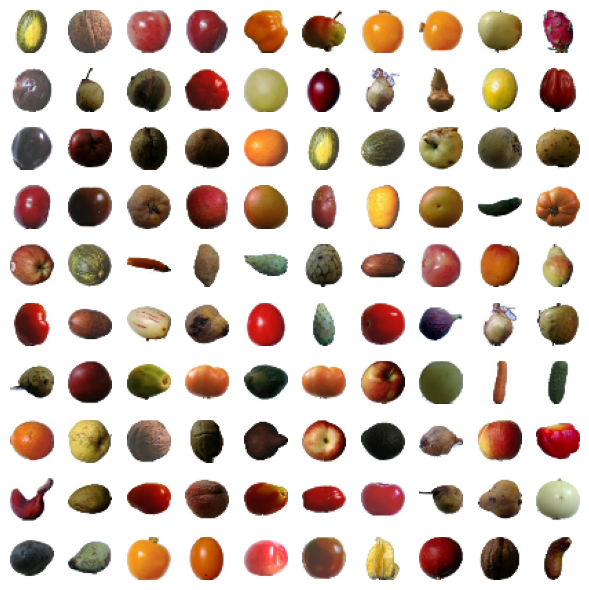

In [57]:
show_img_data(train_x, no=100, layout=(10, 10), figsize=(6, 6))

In [58]:
buffer_size = 60000
train_dataset = tf.data.Dataset.from_tensor_slices(train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2], 3)).shuffle(buffer_size).batch(batch_size)

## Set Up Generator and Discriminator Models

In [59]:
latent_dim = 150

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(latent_dim,))),
    model.add(tf.keras.layers.Dense(4 * 4 * 256, use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((4, 4, 256)))
    assert model.output_shape == (None, 4, 4, 256)

    model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

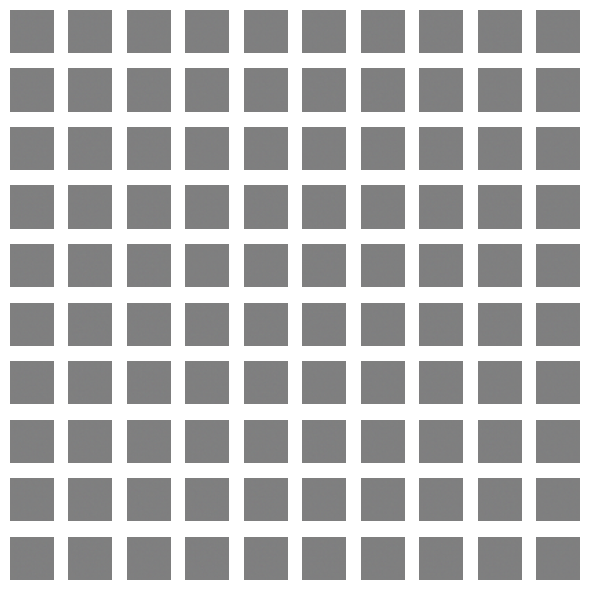

In [60]:
generator = make_generator_model()

noise = tf.random.normal([100, latent_dim])
generated_image = generator(noise, training=False)

show_img_data(generated_image, no=100, layout=(10, 10), figsize=(6, 6))

In [61]:
generator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 4096)           │       614,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 8, 8, 128)      │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 16, 16, 128)    │       262,144 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 32, 32, 128)    │       262,144 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 3)      │         3,456 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,684,352 (6.43 MB)

 Trainable params: 1,675,392 (6.39 MB)

 Non-trainable params: 8,960 (35.00 KB)

In [62]:
def generate_and_show_images(model, test_input):
    # Notice `training` is set to False in order to make sure that
    # all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    show_img_data(predictions, no=min(100, test_input.shape[0]), layout=(10, 10), figsize=(6, 6))

In [63]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(32, 32, 3)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(2))

    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(1))

    return model

In [64]:
discriminator = make_discriminator_model()

In [65]:
discriminator.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │       262,145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 780,545 (2.98 MB)

 Trainable params: 780,545 (2.98 MB)

 Non-trainable params: 0 (0.00 B)

## Define Losses and Optimizers

In [66]:
## This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [67]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [68]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [69]:
generator_optimizer = tf.keras.optimizers.Adam(1.6e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

In [70]:
checkpoint_dir = os.path.join(checkpoint_base_dir, 'Fruits_training_checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the Training Loop

In [71]:
no_epochs = 70
num_examples = 100

# We will reuse this seed over time
gan_seed = tf.random.normal([num_examples, latent_dim])

In [72]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [73]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # show images
        print('Epoch ' + str(epoch + 1) + ' ... finished')

        # save the model every 5 epochs
        if (epoch + 1) % 5 == 0:
            generate_and_show_images(generator, gan_seed)
            checkpoint.save(file_prefix=checkpoint_prefix)

## Run Training

2026-01-22 20:14:58.261571: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1 ... finished
Epoch 2 ... finished
Epoch 3 ... finished
Epoch 4 ... finished


2026-01-22 20:19:15.411962: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5 ... finished


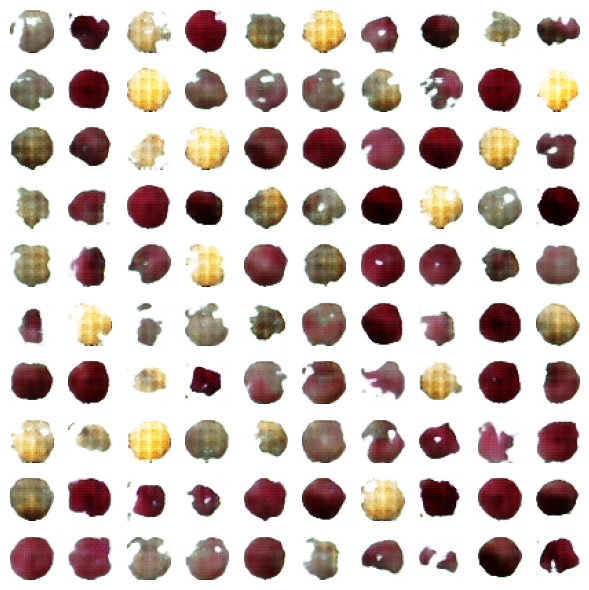

Epoch 6 ... finished
Epoch 7 ... finished
Epoch 8 ... finished
Epoch 9 ... finished
Epoch 10 ... finished


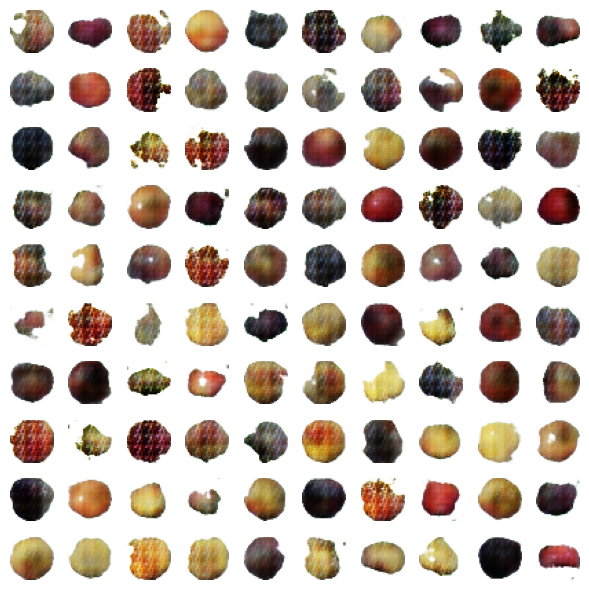

Epoch 11 ... finished
Epoch 12 ... finished


2026-01-22 20:27:54.561371: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 13 ... finished
Epoch 14 ... finished
Epoch 15 ... finished


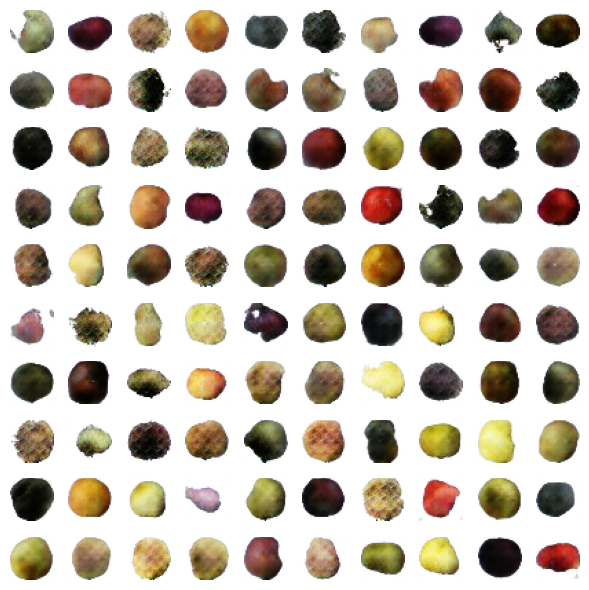

Epoch 16 ... finished
Epoch 17 ... finished
Epoch 18 ... finished
Epoch 19 ... finished
Epoch 20 ... finished


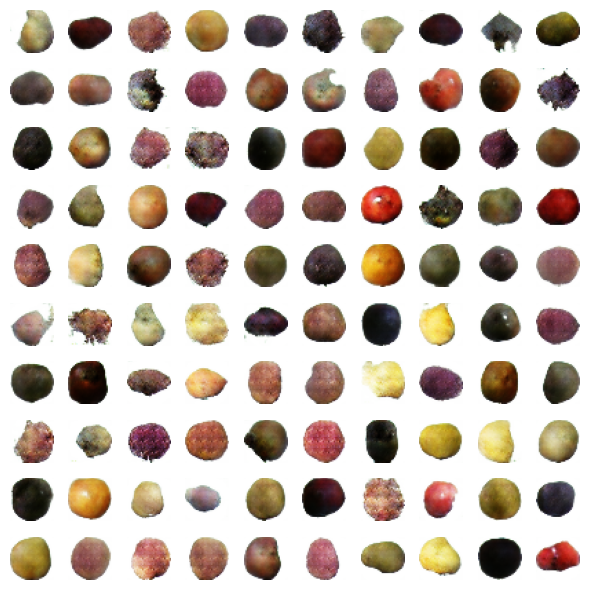

Epoch 21 ... finished
Epoch 22 ... finished
Epoch 23 ... finished
Epoch 24 ... finished
Epoch 25 ... finished


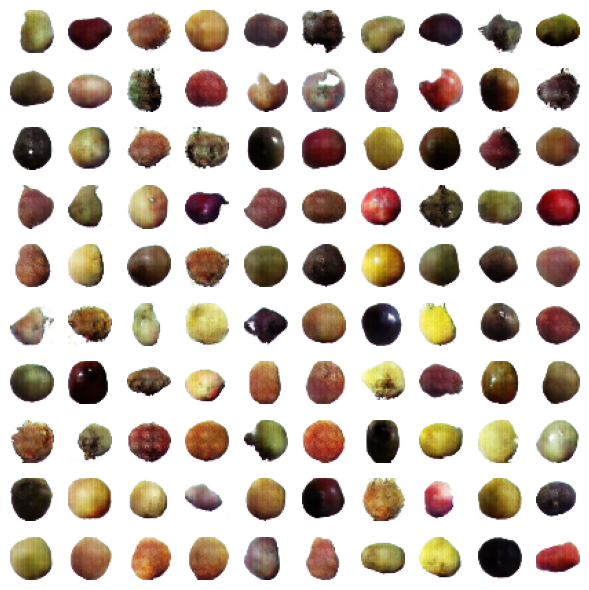

Epoch 26 ... finished
Epoch 27 ... finished
Epoch 28 ... finished


2026-01-22 20:45:03.702700: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 29 ... finished
Epoch 30 ... finished


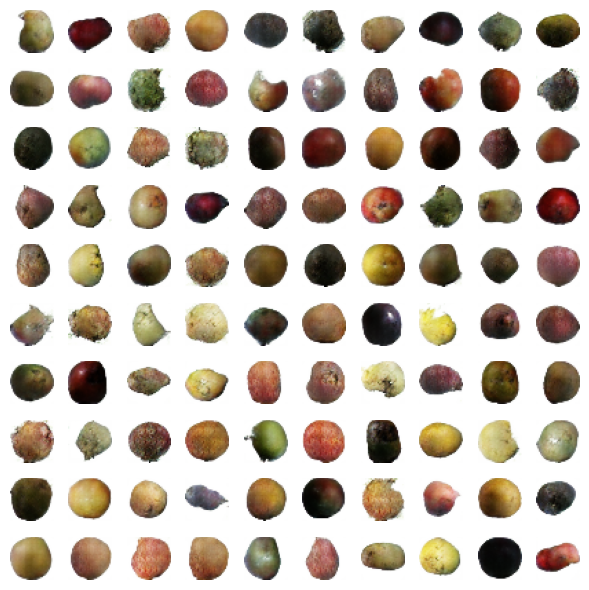

Epoch 31 ... finished
Epoch 32 ... finished
Epoch 33 ... finished
Epoch 34 ... finished
Epoch 35 ... finished


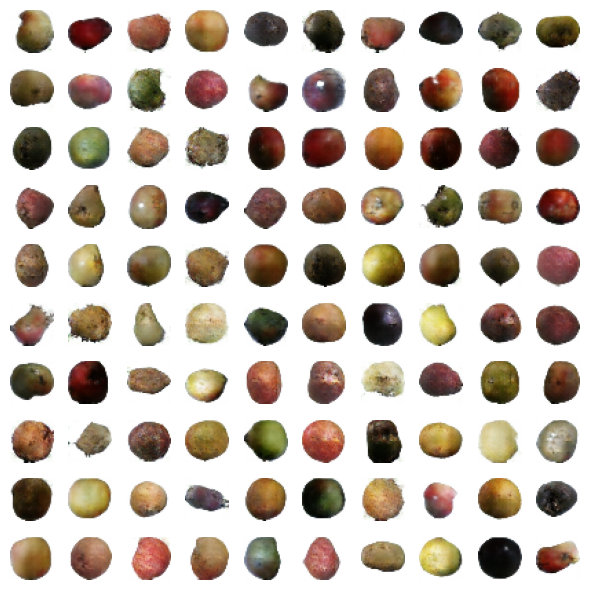

Epoch 36 ... finished
Epoch 37 ... finished
Epoch 38 ... finished
Epoch 39 ... finished
Epoch 40 ... finished


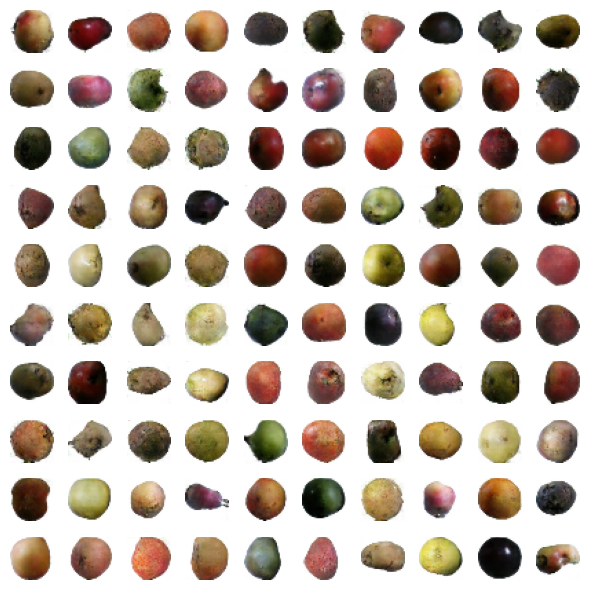

Epoch 41 ... finished
Epoch 42 ... finished
Epoch 43 ... finished
Epoch 44 ... finished
Epoch 45 ... finished


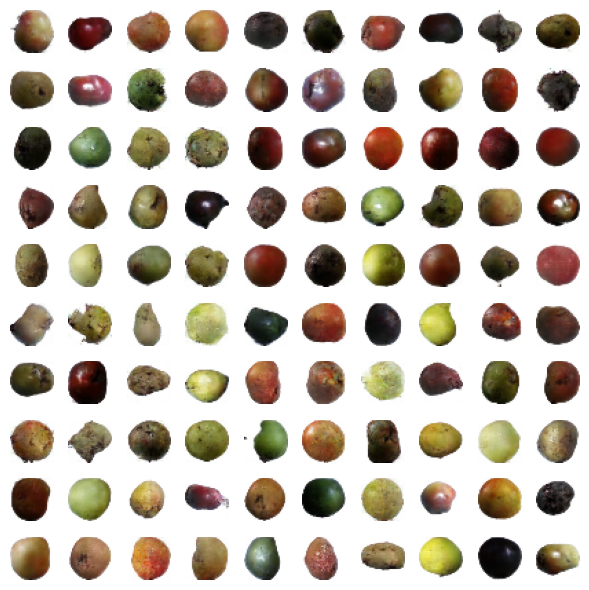

Epoch 46 ... finished
Epoch 47 ... finished
Epoch 48 ... finished
Epoch 49 ... finished
Epoch 50 ... finished


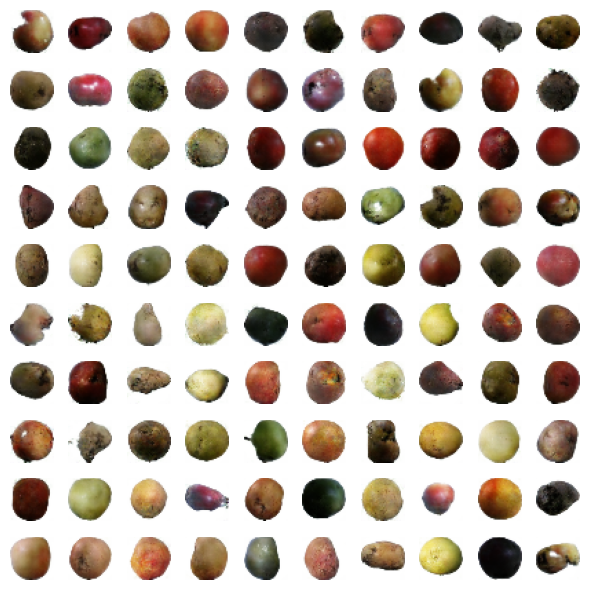

Epoch 51 ... finished
Epoch 52 ... finished
Epoch 53 ... finished
Epoch 54 ... finished
Epoch 55 ... finished


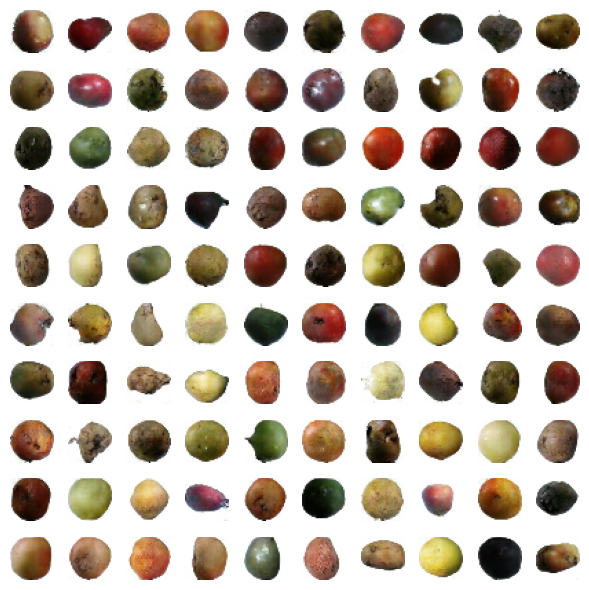

Epoch 56 ... finished
Epoch 57 ... finished
Epoch 58 ... finished
Epoch 59 ... finished
Epoch 60 ... finished


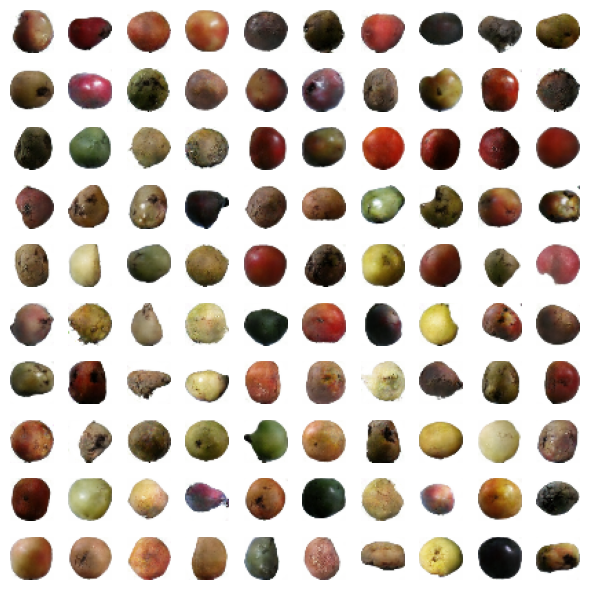

2026-01-22 21:20:04.757737: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 61 ... finished
Epoch 62 ... finished
Epoch 63 ... finished
Epoch 64 ... finished
Epoch 65 ... finished


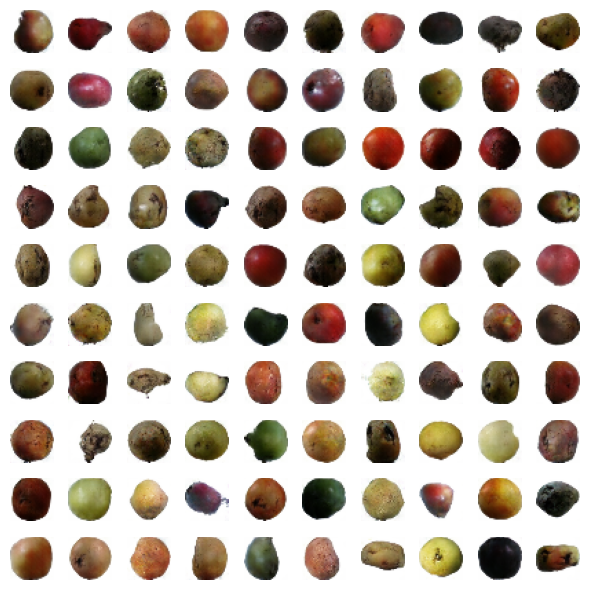

Epoch 66 ... finished
Epoch 67 ... finished
Epoch 68 ... finished
Epoch 69 ... finished
Epoch 70 ... finished


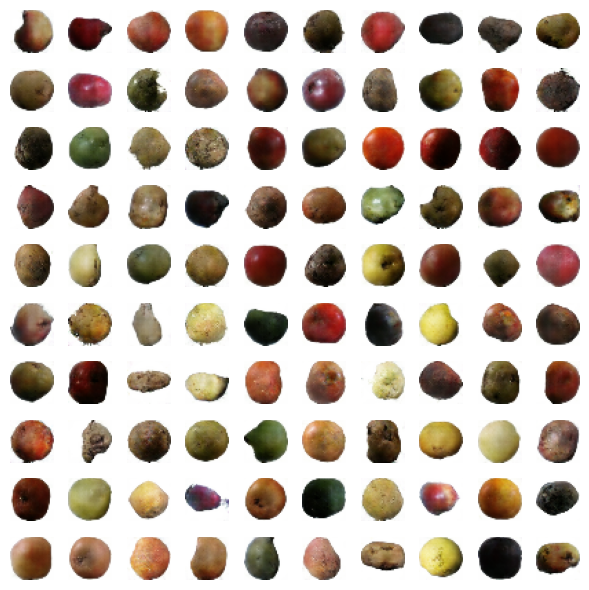

In [74]:
train(train_dataset, no_epochs)

## Play Around with Trained Model

In [75]:
## load latest model
latest = tf.train.latest_checkpoint(checkpoint_dir)
status = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

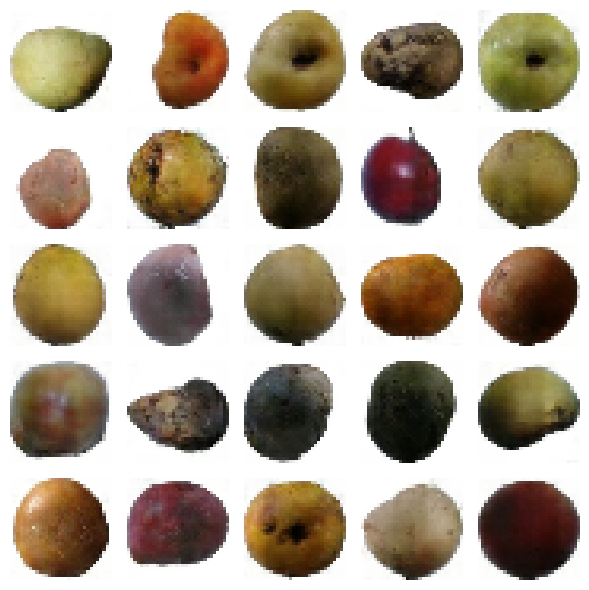

In [ ]:
## generate 100 images
noise = np.random.normal(size=[100, latent_dim])
generated_image = generator(noise, training=False)

show_img_data(generated_image, no=25, layout=(5, 5))